In [1]:
import os
import numpy as np
import torch
import tensorflow as tf
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

2024-06-08 14:15:25.702849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 14:15:25.702969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 14:15:25.820797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [5]:

dataset = tf.keras.utils.get_file(
    fname="20news-18828.tar.gz",
    origin="http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz",
    extract=True,
)

# Tokenizer initialization
SEQ_LEN = 128

14666916/14666916 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Class Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


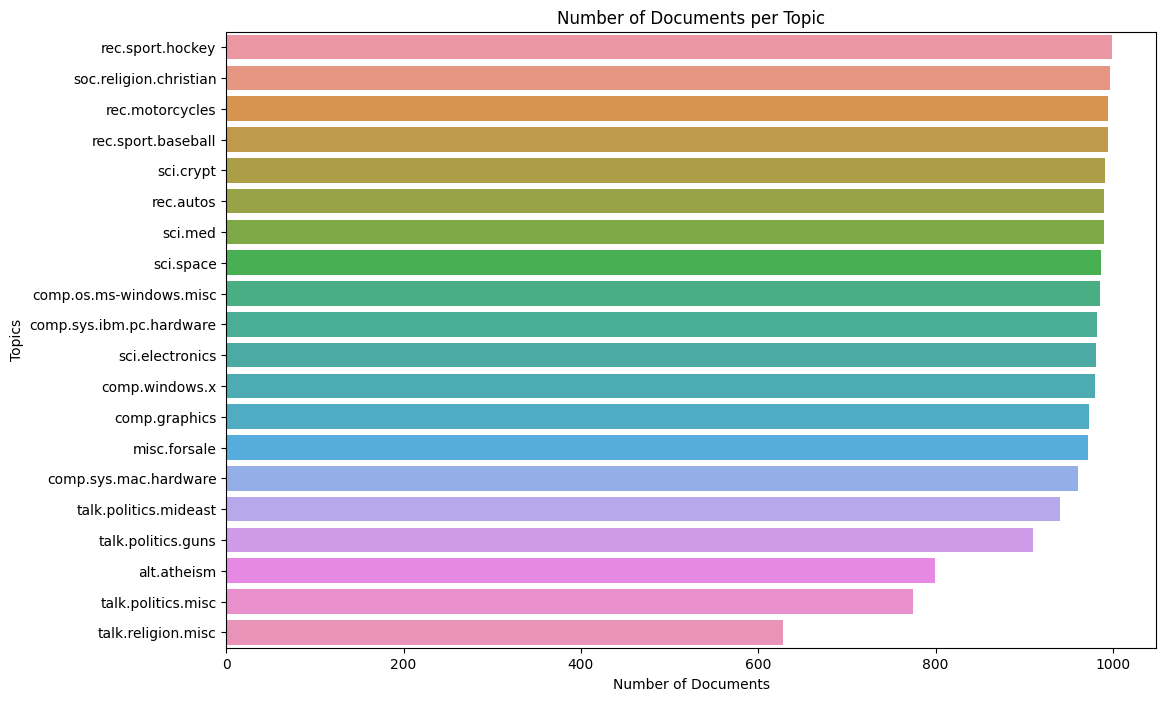

In [9]:
def load_data(path, tagset, tokenizer, batch_size):
    indices, labels = [], []
    for folder, label in tagset:
        folder = os.path.join(path, folder)
        for name in tqdm(os.listdir(folder)):
            with open(os.path.join(folder, name), 'r', encoding="utf-8", errors='ignore') as reader:
                text = reader.read()
            ids = tokenizer.encode(text, max_length=SEQ_LEN, truncation=True, padding='max_length')
            indices.append(ids)
            labels.append(label)

    items = list(zip(indices, labels))
    np.random.shuffle(items)
    indices, labels = zip(*items)
    indices = np.array(indices)
    mod = indices.shape[0] % batch_size
    if mod > 0:
        indices, labels = indices[:-mod], labels[:-mod]
    return np.array(indices), np.array(labels)

path = os.path.join(os.path.dirname(dataset), '20news-18828')
tagset = [(x, i) for i, x in enumerate(sorted(os.listdir(path)))]
id_to_labels = {id_: label for label, id_ in tagset}

# EDA on the topics
labels_count = Counter()
for folder, label in tagset:
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        labels_count[label] = len(os.listdir(folder_path))

labels, counts = zip(*sorted(labels_count.items(), key=lambda x: x[1], reverse=True))
labels = [id_to_labels[label] for label in labels]

# Convert to list to avoid AttributeError
labels = list(labels)
counts = list(counts)

plt.figure(figsize=(12, 8))
sns.barplot(x=counts, y=labels)
plt.xlabel("Number of Documents")
plt.ylabel("Topics")
plt.title("Number of Documents per Topic")
plt.show()

talk.religion misc has the lowest presence in the datset

## Loading the Tokenizer

In [10]:

distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
all_x, all_y = load_data(path, tagset, distilbert_tokenizer, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

100%|██████████| 628/628 [00:08<00:00, 69.92it/s]


## Splitting Dataset

In [11]:
train_perc = 0.7
val_perc = 0.1
total = len(all_y)

n_train = int(train_perc * total)
n_val = int(val_perc * total)
n_test = total - n_train - n_val

train_x, val_x, test_x = all_x[:n_train], all_x[n_train:n_train + n_val], all_x[n_train + n_val:]
train_y, val_y, test_y = all_y[:n_train], all_y[n_train:n_train + n_val], all_y[n_train + n_val:]

print("# Total: %s, # Train: %s, # Validation: %s, # Test: %s" % (total, n_train, n_val, n_test))

# Total: 18816, # Train: 13171, # Validation: 1881, # Test: 3764


## Finetuning With Optuna

In [12]:
def objective_distilbert(trial):
    # Tuning hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    epochs = 10

    # Update the dropout rate in the DistilBERT model configuration
    model_config = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20).config
    model_config.hidden_dropout_prob = dropout_rate
    model_config.attention_probs_dropout_prob = dropout_rate

    # Load data with suggested batch size
    train_data = TensorDataset(torch.tensor(train_x), torch.tensor(train_y))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(torch.tensor(val_x), torch.tensor(val_y))
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    # Load pre-trained DistilBERT model
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=model_config)
    model.to(device)

    # Optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=weight_decay)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    best_accuracy = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)

            optimizer.zero_grad()

            outputs = model(batch_input_ids, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}, Training loss: {avg_train_loss:.4f}")

        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        for batch in validation_dataloader:
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)

            with torch.no_grad():
                outputs = model(batch_input_ids, labels=batch_labels)
                tmp_eval_loss = outputs.loss
                logits = outputs.logits

            eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1

            preds = torch.argmax(logits, axis=1)
            eval_accuracy += (preds == batch_labels).sum().item()
            nb_eval_examples += batch_input_ids.size(0)

        avg_val_accuracy = eval_accuracy / nb_eval_examples
        print(f"Validation accuracy: {avg_val_accuracy:.4f}")

        # Early stopping logic
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict()
            trial.set_user_attr("best_model_state", best_model_state)
        else:
            patience_counter += 1
            if patience_counter >= trial.suggest_int('patience', 1, 3):
                print(f"Early stopping at epoch {epoch+1}")
                break

    return best_accuracy

In [15]:
def print_best_trial(study, trial):
    print(f"Best trial so far: Trial#{trial.number} with value: {trial.value:.4f}")
    print(f"Params: {trial.params}")

study_distilbert = optuna.create_study(direction='maximize')
study_distilbert.optimize(objective_distilbert, n_trials=10, callbacks=[print_best_trial])

[I 2024-06-08 15:20:10,436] A new study created in memory with name: no-name-7f5ba8ec-5e67-48a3-bd12-b57f7e41cc3f
/tmp/ipykernel_34/3646895306.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
/tmp/ipykernel_34/3646895306.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/tmp/ipykernel_34/3646895306.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dr

Epoch 1, Training loss: 0.9798
Validation accuracy: 0.8591
Epoch 2, Training loss: 0.3124
Validation accuracy: 0.8942
Epoch 3, Training loss: 0.1474
Validation accuracy: 0.9064
Epoch 4, Training loss: 0.0830
Validation accuracy: 0.9133
Epoch 5, Training loss: 0.0446
Validation accuracy: 0.9187
Epoch 6, Training loss: 0.0299
Validation accuracy: 0.9197
Epoch 7, Training loss: 0.0161
Validation accuracy: 0.9213
Epoch 8, Training loss: 0.0093
Validation accuracy: 0.9229
Epoch 9, Training loss: 0.0056
Validation accuracy: 0.9213
Epoch 10, Training loss: 0.0028


[I 2024-06-08 15:34:19,576] Trial 0 finished with value: 0.9229133439659756 and parameters: {'learning_rate': 3.7070032458394976e-05, 'batch_size': 16, 'weight_decay': 0.0002688923485505854, 'warmup_steps': 1, 'dropout_rate': 0.40539083473306103, 'patience': 3}. Best is trial 0 with value: 0.9229133439659756.


Validation accuracy: 0.9224
Best trial so far: Trial#0 with value: 0.9229
Params: {'learning_rate': 3.7070032458394976e-05, 'batch_size': 16, 'weight_decay': 0.0002688923485505854, 'warmup_steps': 1, 'dropout_rate': 0.40539083473306103, 'patience': 3}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.1173
Validation accuracy: 0.8650
Epoch 2, Training loss: 0.3269
Validation accuracy: 0.8915
Epoch 3, Training loss: 0.1594
Validation accuracy: 0.9038
Epoch 4, Training loss: 0.0845
Validation accuracy: 0.9144
Epoch 5, Training loss: 0.0489
Validation accuracy: 0.9208
Epoch 6, Training loss: 0.0269
Validation accuracy: 0.9155
Epoch 7, Training loss: 0.0148
Validation accuracy: 0.9208
Epoch 8, Training loss: 0.0098
Validation accuracy: 0.9256
Epoch 9, Training loss: 0.0062
Validation accuracy: 0.9272
Epoch 10, Training loss: 0.0041


[I 2024-06-08 15:48:28,982] Trial 1 finished with value: 0.9282296650717703 and parameters: {'learning_rate': 2.8996402907414082e-05, 'batch_size': 16, 'weight_decay': 1.669040976228297e-06, 'warmup_steps': 56, 'dropout_rate': 0.349038165679615, 'patience': 3}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.9282
Best trial so far: Trial#1 with value: 0.9282
Params: {'learning_rate': 2.8996402907414082e-05, 'batch_size': 16, 'weight_decay': 1.669040976228297e-06, 'warmup_steps': 56, 'dropout_rate': 0.349038165679615, 'patience': 3}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.2789
Validation accuracy: 0.8171
Epoch 2, Training loss: 0.7269
Validation accuracy: 0.8368
Epoch 3, Training loss: 0.4214
Validation accuracy: 0.8687
Epoch 4, Training loss: 0.1907
Validation accuracy: 0.8921
Epoch 5, Training loss: 0.1003
Validation accuracy: 0.8868
Epoch 6, Training loss: 0.0539
Validation accuracy: 0.8985
Epoch 7, Training loss: 0.0331
Validation accuracy: 0.8974
Epoch 8, Training loss: 0.0198
Validation accuracy: 0.8915
Epoch 9, Training loss: 0.0117


[I 2024-06-08 16:00:20,098] Trial 2 finished with value: 0.8984582668793195 and parameters: {'learning_rate': 0.0003534486830989897, 'batch_size': 32, 'weight_decay': 4.962477527807273e-05, 'warmup_steps': 471, 'dropout_rate': 0.42202706978307003, 'patience': 3}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.8942
Early stopping at epoch 9
Best trial so far: Trial#2 with value: 0.8985
Params: {'learning_rate': 0.0003534486830989897, 'batch_size': 32, 'weight_decay': 4.962477527807273e-05, 'warmup_steps': 471, 'dropout_rate': 0.42202706978307003, 'patience': 3}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.3292
Validation accuracy: 0.8230
Epoch 2, Training loss: 0.4457
Validation accuracy: 0.8894
Epoch 3, Training loss: 0.2404
Validation accuracy: 0.9001
Epoch 4, Training loss: 0.1465
Validation accuracy: 0.9091
Epoch 5, Training loss: 0.0873
Validation accuracy: 0.9102
Epoch 6, Training loss: 0.0591


[I 2024-06-08 16:08:50,053] Trial 3 finished with value: 0.910154173312068 and parameters: {'learning_rate': 1.5368244648243737e-05, 'batch_size': 16, 'weight_decay': 8.871281336957359e-06, 'warmup_steps': 62, 'dropout_rate': 0.28540568094391716, 'patience': 1}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.9086
Early stopping at epoch 6
Best trial so far: Trial#3 with value: 0.9102
Params: {'learning_rate': 1.5368244648243737e-05, 'batch_size': 16, 'weight_decay': 8.871281336957359e-06, 'warmup_steps': 62, 'dropout_rate': 0.28540568094391716, 'patience': 1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.7970
Validation accuracy: 0.7969
Epoch 2, Training loss: 0.5193
Validation accuracy: 0.8756
Epoch 3, Training loss: 0.2699
Validation accuracy: 0.8969
Epoch 4, Training loss: 0.1585
Validation accuracy: 0.8937
Epoch 5, Training loss: 0.0952
Validation accuracy: 0.9139
Epoch 6, Training loss: 0.0651
Validation accuracy: 0.9133
Epoch 7, Training loss: 0.0444
Validation accuracy: 0.9160
Epoch 8, Training loss: 0.0303
Validation accuracy: 0.9176
Epoch 9, Training loss: 0.0245
Validation accuracy: 0.9171
Epoch 10, Training loss: 0.0205


[I 2024-06-08 16:21:59,127] Trial 4 finished with value: 0.9175970228601807 and parameters: {'learning_rate': 2.060789154856456e-05, 'batch_size': 32, 'weight_decay': 2.848480819587362e-05, 'warmup_steps': 199, 'dropout_rate': 0.3680720100734276, 'patience': 2}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.9171
Early stopping at epoch 10
Best trial so far: Trial#4 with value: 0.9176
Params: {'learning_rate': 2.060789154856456e-05, 'batch_size': 32, 'weight_decay': 2.848480819587362e-05, 'warmup_steps': 199, 'dropout_rate': 0.3680720100734276, 'patience': 2}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.2643
Validation accuracy: 0.8495
Epoch 2, Training loss: 0.3532
Validation accuracy: 0.8931
Epoch 3, Training loss: 0.1672


[I 2024-06-08 16:25:56,278] Trial 5 finished with value: 0.8931419457735247 and parameters: {'learning_rate': 9.452155554120773e-05, 'batch_size': 32, 'weight_decay': 0.0025544316599735504, 'warmup_steps': 200, 'dropout_rate': 0.13239292703749853, 'patience': 1}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.8926
Early stopping at epoch 3
Best trial so far: Trial#5 with value: 0.8931
Params: {'learning_rate': 9.452155554120773e-05, 'batch_size': 32, 'weight_decay': 0.0025544316599735504, 'warmup_steps': 200, 'dropout_rate': 0.13239292703749853, 'patience': 1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.1726
Validation accuracy: 0.7826
Epoch 2, Training loss: 0.5048
Validation accuracy: 0.8453
Epoch 3, Training loss: 0.2746
Validation accuracy: 0.8825
Epoch 4, Training loss: 0.1658
Validation accuracy: 0.8873
Epoch 5, Training loss: 0.0909
Validation accuracy: 0.9016
Epoch 6, Training loss: 0.0540


[I 2024-06-08 16:34:26,172] Trial 6 finished with value: 0.9016480595427964 and parameters: {'learning_rate': 0.0002198879747451661, 'batch_size': 16, 'weight_decay': 0.00016892322691763602, 'warmup_steps': 208, 'dropout_rate': 0.17171307548318118, 'patience': 1}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.9001
Early stopping at epoch 6
Best trial so far: Trial#6 with value: 0.9016
Params: {'learning_rate': 0.0002198879747451661, 'batch_size': 16, 'weight_decay': 0.00016892322691763602, 'warmup_steps': 208, 'dropout_rate': 0.17171307548318118, 'patience': 1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.6688
Validation accuracy: 0.8336
Epoch 2, Training loss: 0.4268
Validation accuracy: 0.8862
Epoch 3, Training loss: 0.2035
Validation accuracy: 0.9048
Epoch 4, Training loss: 0.1059
Validation accuracy: 0.9155
Epoch 5, Training loss: 0.0610
Validation accuracy: 0.9165
Epoch 6, Training loss: 0.0370
Validation accuracy: 0.9224
Epoch 7, Training loss: 0.0234
Validation accuracy: 0.9240
Epoch 8, Training loss: 0.0150
Validation accuracy: 0.9219
Epoch 9, Training loss: 0.0100


[I 2024-06-08 16:46:15,837] Trial 7 finished with value: 0.9239766081871345 and parameters: {'learning_rate': 3.531156395788416e-05, 'batch_size': 32, 'weight_decay': 0.009860742842467287, 'warmup_steps': 284, 'dropout_rate': 0.19593761945172028, 'patience': 2}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.9234
Early stopping at epoch 9
Best trial so far: Trial#7 with value: 0.9240
Params: {'learning_rate': 3.531156395788416e-05, 'batch_size': 32, 'weight_decay': 0.009860742842467287, 'warmup_steps': 284, 'dropout_rate': 0.19593761945172028, 'patience': 2}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.6325
Validation accuracy: 0.8166
Epoch 2, Training loss: 0.4304
Validation accuracy: 0.8974
Epoch 3, Training loss: 0.1960
Validation accuracy: 0.9128
Epoch 4, Training loss: 0.0891
Validation accuracy: 0.9160
Epoch 5, Training loss: 0.0507


[I 2024-06-08 16:52:50,253] Trial 8 finished with value: 0.9160021265284424 and parameters: {'learning_rate': 4.230615398764574e-05, 'batch_size': 32, 'weight_decay': 3.5257119315671605e-05, 'warmup_steps': 304, 'dropout_rate': 0.45895176484368605, 'patience': 1}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.9133
Early stopping at epoch 5
Best trial so far: Trial#8 with value: 0.9160
Params: {'learning_rate': 4.230615398764574e-05, 'batch_size': 32, 'weight_decay': 3.5257119315671605e-05, 'warmup_steps': 304, 'dropout_rate': 0.45895176484368605, 'patience': 1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training loss: 1.2900
Validation accuracy: 0.8299
Epoch 2, Training loss: 0.4079
Validation accuracy: 0.8825
Epoch 3, Training loss: 0.1963
Validation accuracy: 0.8995
Epoch 4, Training loss: 0.1074
Validation accuracy: 0.9064
Epoch 5, Training loss: 0.0608
Validation accuracy: 0.9080
Epoch 6, Training loss: 0.0371
Validation accuracy: 0.9038
Epoch 7, Training loss: 0.0182
Validation accuracy: 0.9181
Epoch 8, Training loss: 0.0083
Validation accuracy: 0.9181
Epoch 9, Training loss: 0.0044
Validation accuracy: 0.9192
Epoch 10, Training loss: 0.0027


[I 2024-06-08 17:05:58,511] Trial 9 finished with value: 0.9207868155236576 and parameters: {'learning_rate': 0.00015677212839147265, 'batch_size': 32, 'weight_decay': 5.199326534447739e-06, 'warmup_steps': 332, 'dropout_rate': 0.3337170273035761, 'patience': 2}. Best is trial 1 with value: 0.9282296650717703.


Validation accuracy: 0.9208
Best trial so far: Trial#9 with value: 0.9208
Params: {'learning_rate': 0.00015677212839147265, 'batch_size': 32, 'weight_decay': 5.199326534447739e-06, 'warmup_steps': 332, 'dropout_rate': 0.3337170273035761, 'patience': 2}


## Load the best model state

In [16]:

best_model_state = study_distilbert.best_trial.user_attrs['best_model_state']
best_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20)
best_model.load_state_dict(best_model_state)
best_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Model Evaluation on Test set

In [24]:
from sklearn.metrics import classification_report

# Load the best model state
best_model_state = study_distilbert.best_trial.user_attrs['best_model_state']
best_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20)
best_model.load_state_dict(best_model_state)
best_model.to(device)

# Evaluate on test set
test_data = TensorDataset(torch.tensor(test_x), torch.tensor(test_y))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)

best_model.eval()
test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = 0, 0, 0, 0, 0
nb_test_examples = 0
all_logits, all_labels = [], []

for batch in test_dataloader:
    batch_input_ids, batch_labels = batch
    batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)

    with torch.no_grad():
        outputs = best_model(batch_input_ids)
        logits = outputs.logits

    preds = torch.argmax(logits, axis=1)
    test_accuracy += (preds == batch_labels).sum().item()

    all_logits.extend(logits.cpu().numpy())
    all_labels.extend(batch_labels.cpu().numpy())
    nb_test_examples += batch_input_ids.size(0)

test_accuracy /= nb_test_examples
test_precision = precision_score(all_labels, np.argmax(all_logits, axis=1), average='macro')
test_recall = recall_score(all_labels, np.argmax(all_logits, axis=1), average='macro')
test_f1 = f1_score(all_labels, np.argmax(all_logits, axis=1), average='macro')

# Compute ROC-AUC score for each class
one_hot_labels = np.eye(20)[all_labels]  # Convert labels to one-hot encoding
test_roc_auc = roc_auc_score(one_hot_labels, all_logits, average='macro', multi_class='ovr')

# Print overall metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test ROC-AUC Score: {test_roc_auc:.4f}")

# Print classification report for each class
class_report = classification_report(all_labels, np.argmax(all_logits, axis=1), target_names=[id_to_labels[i] for i in range(20)])
print("\nClassification Report:\n", class_report)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.9203
Test Precision: 0.9201
Test Recall: 0.9191
Test F1 Score: 0.9195
Test ROC-AUC Score: 0.9916

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.94      0.88      0.91       166
           comp.graphics       0.87      0.86      0.87       207
 comp.os.ms-windows.misc       0.89      0.89      0.89       189
comp.sys.ibm.pc.hardware       0.78      0.81      0.79       210
   comp.sys.mac.hardware       0.89      0.86      0.88       185
          comp.windows.x       0.94      0.95      0.94       206
            misc.forsale       0.89      0.92      0.90       191
               rec.autos       0.96      0.93      0.95       195
         rec.motorcycles       0.95      0.96      0.95       200
      rec.sport.baseball       0.96      0.96      0.96       195
        rec.sport.hockey       0.99      0.98      0.99       202
               sci.crypt       0.96      0.98      0.97       187
  

## Test random sentences

In [23]:

random_sentences = [
    "Ford came out with a new hybrid engine model.",
    "The new movie released this weekend was a huge hit.",
    "The local sports team won their game last night.",
    "Advancements in AI technology are rapidly changing the industry.",
    "The recent election results have sparked a lot of debates."
]

# Tokenize and encode the sentences
inputs = distilbert_tokenizer(random_sentences, return_tensors="pt", padding=True, truncation=True, max_length=SEQ_LEN)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Model evaluation
best_model.eval()
with torch.no_grad():
    outputs = best_model(**inputs)
    logits = outputs.logits

predictions = torch.argmax(logits, axis=1).cpu().numpy()
predicted_labels = [id_to_labels[pred] for pred in predictions]

# Display results
for sentence, label in zip(random_sentences, predicted_labels):
    print(f"Sentence: {sentence}")
    print(f"Predicted Topic: {label}")
    print()

Sentence: Ford came out with a new hybrid engine model.
Predicted Topic: rec.autos

Sentence: The new movie released this weekend was a huge hit.
Predicted Topic: misc.forsale

Sentence: The local sports team won their game last night.
Predicted Topic: rec.sport.hockey

Sentence: Advancements in AI technology are rapidly changing the industry.
Predicted Topic: comp.sys.mac.hardware

Sentence: The recent election results have sparked a lot of debates.
Predicted Topic: talk.politics.misc

